In [1]:
import torch
import math
import pyro
from pyro.infer import HMC, MCMC, SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyro.distributions import LogNormal, Binomial
from torch.distributions import constraints
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scistats
from scipy.special import binom

In [56]:
#prior specifies our prior belief regarding how much pg-pairs the child could have been exposed to
prior_mu = np.log(500) # means that the median pg-pair exposure in our prior belief is 500
prior_sigma = 0.1 # specifies how spreaded the prior is. For the actual modeling, we want it to be 
                  # quite spreaded. So, the value around 2-3 shall be best. I put it small here to better
                  # show how prior belief can influence our posterior belief.

In [57]:
p_th = 0.01 # probability of our target pg-pair, derived from corpus
n_th_observed = 0 # how much the kid saw this pg-pair
observations = torch.tensor([p_th_observed])

In [58]:
nmax = 10000 # for our simple model, we are going to first do exact posterior calculation. This is very fast
            # with this model, but it will become infeasible with more complex models. We want some reasonable
            # range of possible pg-exposures for this computation. Let's say that it is about 0 and 10000.

In [59]:
# this function computes the discretized lognormal probabilities for a certain range. It uses integral
# over PDF (probability density function) of normal distribution between f(x[i]) and f(x[i+1]), where
# f is the inverse of the transform between normal and lognormal. This integral is
# expressed via CDF (cumulative density function) of the normal distribution
def lognorm_probs(mu, sigma, maxn):
    xs = np.arange(maxn + 1)
    cdfs = np.zeros_like(xs, dtype = float)
    cdfs[xs > 0] = scistats.norm.cdf((np.log(xs[xs > 0]) - mu) / sigma)
    return cdfs[1:] - cdfs[:-1]

In [60]:
prior_ps = lognorm_probs(prior_mu, prior_sigma, nmax)

In [61]:
# this function computes posterior probabilities using the bayes rule. we can do it in this case,
# because we can easily enumerate all hidden states
# prior_probs is the prior probability of total pg number, p is the probability of a pg-pair,
# and obs is the observed number of this pg-pair
def posterior_probs(prior_probs, p, obs):
    observation_probs = np.zeros_like(prior_probs, dtype = float)
    # compute the probability of sampling the observed number of this pg-pair for all possible total pg-numbers:
    observation_probs[obs:] = binom(np.arange(obs, nmax), obs) * np.power((1 - p), np.arange(nmax - obs))
    # applying the Bayes rule: multiply prior probabilities by observation probabilities, then re-normalize:
    posterior_ps = prior_probs * observation_probs
    posterior_ps /= np.sum(posterior_ps)
    return posterior_ps

In [62]:
post_ps = posterior_probs(prior_ps, p_th, n_th_observed)

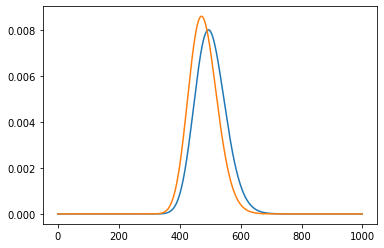

In [63]:
# look at our posterior! It does look pretty much lognormal. Intuitively, that makes a lot of sense:
# lognormal sort of specifies the order of magnitude of the target value; the bigger it is, the less
# precise the measurement becomes (the error is proportional to the value). And it make sense that when
# we estimate the number of pg-pairs the kid was exposed to, we also are going to get more of an order of
# magnitude than exact number.

plt.plot(prior_ps[:1000])
plt.plot(post_ps[:1000])

In [53]:
# this is the model that we would actually want to have. However, I didn't have much luck running it:
# neither with sampling (very slow), nor with variational inference (doesn't converge)
def ideal_model(observations):
    log_n = pyro.sample("log_n_pg_exposed", pyro.distributions.Normal(np.log(500), 0.1))
    pyro.sample("n_th_exposed", pyro.distributions.Binomial(total_count = torch.exp(log_n), probs = p_th), obs = observations[0]) 

In [54]:
# this is a model that replaces the binomial with its continuous approximation (from Central Limit Theorem)
# this seems to actually work
def approximate_model(observations):
    log_n = pyro.sample("log_n_pg_exposed", pyro.distributions.Normal(np.log(500), 0.1))
    n = torch.exp(log_n)
    pyro.sample("n_th_exposed", pyro.distributions.Normal(loc = n * p_th, scale = math.sqrt(n * p_th * (1 - p_th))), obs = observations[0])

In [55]:
# this is how we would run sampling. Doesn't work! Way too slow!

# pyro.clear_param_store()
# my_kernel = HMC(model)
# my_mcmc = MCMC(my_kernel,
#                num_samples=1000,
#                warmup_steps=100)
# my_mcmc.run(observations)

In [82]:
# This function parametrizes the posterior. Based on considerations described above, I chose the posterior
# number of pg-exposures to come from log-normal. Here, I actually chose to parametrize the log of this value
# (using normal). I think the log parametrization is going to be better, because it naturally accounts for the
# fact that the higher is the mu, the less precision we are going to have.

# I initialize the posterior with the same mu as the prior - it seems to converge quite well
# from that point. But different initializations could be tried.

def guide(observations):
    mu = pyro.param("mu", torch.tensor(prior_mu))
    sigma = pyro.param("sigma", torch.tensor(2), constraint=constraints.positive)
    pyro.sample("log_n_pg_exposed", pyro.distributions.Normal(mu, sigma))

In [ ]:
pyro.clear_param_store()

# Define our SVI algorithm. It accepts our model
# our guide, an optimizer, and a loss function
# to maximize
svi = SVI(model=approximate_model,
             guide=guide,
             optim=ClippedAdam({"lr": 0.001}),
             loss=Trace_ELBO())

# Decide on the number of optimization steps to 
# take, and run the optimizer for that
# many steps.

# We sent the parameters into model and guide
# in the .step() function

optimization_steps = 10000
losses, mus, sigmas  = [], [], []
for i in range(10000):
    if 0 == i % 100: print(i)
    losses.append(svi.step(observations))
    mus.append(pyro.param("mu").item())
    sigmas.append(pyro.param("sigma").item())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [ ]:
plt.plot(losses)

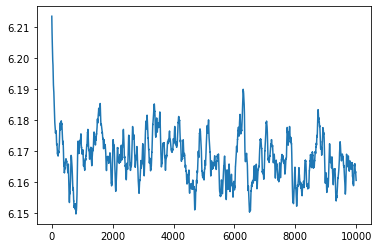

In [78]:
plt.plot(mus)

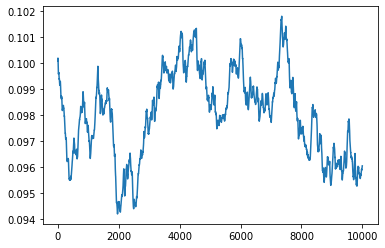

In [79]:
plt.plot(sigmas)

In [80]:
# let's convert our predicted mu and sigma (the last ones in the iteration chain) 
# into the posterior probability distribution!
variational_posterior = lognorm_probs(mus[-1], sigmas[-1], nmax)

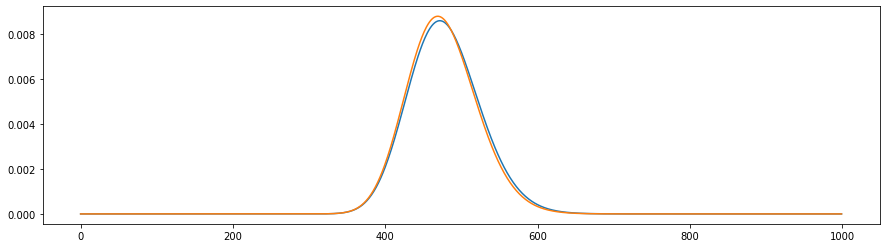

In [81]:
# the match seems to be quite good!
plt.gcf().set_size_inches(15, 4)
plt.plot(post_ps[:1000])
plt.plot(variational_posterior[:1000])